# Google Trends to Google Data Studio

1. Get the result form `Google Trends`
2. Using [gspread](https://github.com/burnash/gspread) transform the data of `Google Trends` to `Google Sheets`
3. Import the file of `Google Sheets` into `Google Data Studio`

## Get the result from `Goolge Trends`

In [1]:
import pandas as pd
from pytrends.request import TrendReq

# Create an instance(實例) of TrendReq
pytrend = TrendReq()

# Build a payload
pytrend.build_payload(kw_list=['Coronavirus'], timeframe='2020-01-01 2020-06-04')

# Requset data: Interest Over Time
covid_19_interest_over_time_df = pytrend.interest_over_time()
covid_19_interest_over_time_df.tail()

,Coronavirus,isPartial
date,,
2020-05-29,14,False
2020-05-30,14,False
2020-05-31,14,False
2020-06-01,13,False
2020-06-02,13,False


## Plot the result

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
plt.style.use('fivethirtyeight')

# 中文
plt.rcParams['font.sans-serif'] = ['Noto Sans Mono CJK TC', 'sans-serif'] 
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

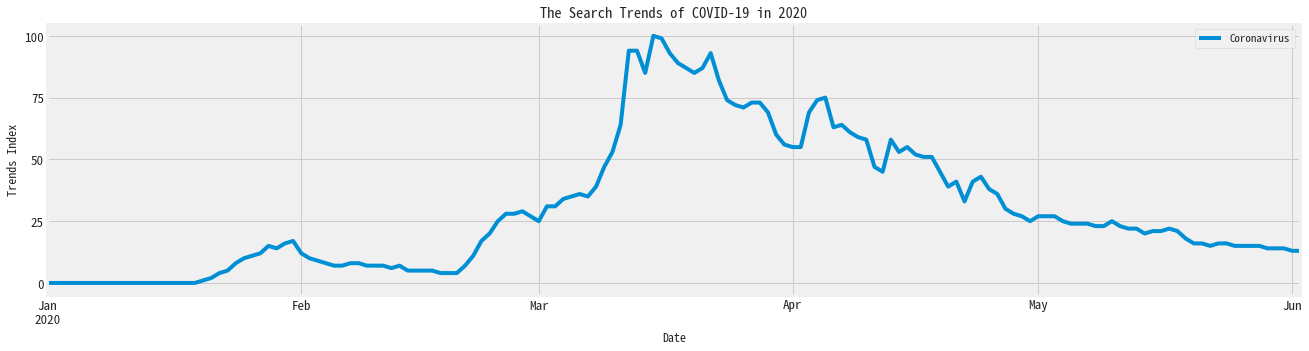

In [3]:
axes = covid_19_interest_over_time_df.plot.line(
    figsize=(20,5),
    title='The Search Trends of COVID-19 in 2020')
axes.set_yticks([0, 25, 50, 75, 100])
axes.set_xlabel('Date')
axes.set_ylabel('Trends Index')
axes.tick_params(axis='both', which='major', labelsize=13)

## Using `gspread` transform the data of `Google Trends` to `Google Sheets`

Reference: [Access spreadsheets via Google Sheets API.](https://gspread.readthedocs.io/en/latest/oauth2.html)

### Install the required packages

- [gspread](https://github.com/burnash/gspread)
- [oauth2client](https://github.com/googleapis/oauth2client)

In [ ]:
!pip3 install gspread oauth2client

### 申請帳號並啟用API

因為我們要存取 `Google sheets`，
所以我們必須打開原本Google帳號的權限（或是申請一個新的帳號）

1. 到 [Google Cloud Platform](https://console.developers.google.com/?hl=zh-tw) 建立一個`Project`

    新增專案 -> 專案名稱:`google-sheets` -> 建立

    ![](./images/google_apis_create_an_project_1.png)

    ![](./images/google_apis_create_an_project_2.png)


2. 啟動該`Project`的 API

    啟用API和服務 -> 在搜尋API和服務打上`Drive API` -> 啟用 -> 在搜尋API和服務打上`Sheets API(Google Sheets)` -> 啟用
         
    ![](./images/google_apis_active_api_1.png)
    
    ![](./images/google_apis_active_api_2.png)
        
    ![](./images/google_apis_active_api_3.png)
    
    ![](./images/google_apis_active_api_4.png)
    
    ![](./images/google_apis_active_api_5.png)
    
    ![](./images/google_apis_active_api_6.png)


3. 建立憑證(Credentials)
   
   回到首頁點選憑證 -> 建立憑證 -> 選服務帳號 -> 服務帳號詳細資料：`Google Trends to Google Sheets` -> 建立 -> 繼續 -> 建立金鑰 -> 選擇 `JSON` -> 建立 -> 完成
   
   ![](./images/google_apis_create_credentials_1.png)
   
   ![](./images/google_apis_create_credentials_2.png)
   
   ![](./images/google_apis_create_credentials_3.png)
   
   ![](./images/google_apis_create_credentials_4.png)
   
   ![](./images/google_apis_create_credentials_5.png)
   
   ![](./images/google_apis_create_credentials_6.png)


4. 將下載好的`JSON`檔案取名為`auth.json`
   

### 建立試算表

透過`gspread`建立並使用試算表有兩種方式

1. 在`Google Drive`或是[Google Sheets](https://sheets.google.com)建立試算表，並將開試算表分享給剛剛下載的`JSON`裡的`client_email`裡的帳號: `name...@...gserviceaccount.com`使用，並給予編輯的權限，這樣才有辦法透過程式存取。

2. 透過`gspread`的`create()`創建試算表

    ```python
    sh = gc.create('A new spreadsheet')
    ```
##### Note: 
    
    ```
    If you’re using a service account, 
    this new spreadsheet will be visible only to your script's account. 
    To be able to access newly created spreadsheet 
    from Google Sheets with your own Google account you must share it with your email. 
    See how to share a spreadsheet in the section below.
    ```
     
    - Sharing a Spreadsheet:
        
        ```python
        sh.share('your_email', perm_type='user', role='writer')
        ```


以下使用第二種方法！

#### Connect to `Google Sheets`

In [4]:
import gspread
from google.oauth2.service_account import Credentials

In [5]:
def google_oauth2_service(auth_path, scopes):
    credentials = Credentials.from_service_account_file(
        auth_path,
        scopes=scopes
    )
    
    return gspread.authorize(credentials)

In [6]:
scopes = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

auth_path = 'google_sheets_auth.json'

gc = google_oauth2_service(auth_path, scopes)

#### Connetc and share a spreadsheet

In [7]:
# Create a spreadsheet
sh = gc.create("COVID-19 Search Trends")

# Share a spreadsheet
sh.share('vn503024@gmail.com', perm_type='user', role='writer')

### Select a worksheet

Select worksheet by index. Worksheet indexes start from zero:

```python
worksheet = sh.get_worksheet(0)
```

Or by title:

```python
worksheet = sh.worksheet("January")
```

Or the most common case: Sheet1:

```python
worksheet = sh.sheet1
```

To get a list of all worksheets:

```python
worksheet_list = sh.worksheets()
```

In [8]:
worksheet = gc.open("COVID-19 Search Trends").sheet1

### Update value of cell: send `DataFrame` into `sheet`

#### Prepocess DataFrame

1. `reset_index()`: 因為我們需要date這個欄位
2. conver datatime to string: 
    ```
    Object of type 'Timestamp' is not JSON serializable
    ```

In [9]:
covid_19_interest_over_time_df

,Coronavirus,isPartial
date,,
2020-01-01,0,False
2020-01-02,0,False
2020-01-03,0,False
2020-01-04,0,False
2020-01-05,0,False
...,...,...
2020-05-29,14,False
2020-05-30,14,False
2020-05-31,14,False


In [10]:
covid_19_interest_over_time_df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31',
               '2020-06-01', '2020-06-02'],
              dtype='datetime64[ns]', name='date', length=154, freq=None)

1. Reset index

In [11]:
covid_19_interest_over_time_df.reset_index(inplace=True)
covid_19_interest_over_time_df

,date,Coronavirus,isPartial
0,2020-01-01,0,False
1,2020-01-02,0,False
2,2020-01-03,0,False
3,2020-01-04,0,False
4,2020-01-05,0,False
...,...,...,...
149,2020-05-29,14,False
150,2020-05-30,14,False
151,2020-05-31,14,False
152,2020-06-01,13,False


2. Convert datatime to string

In [12]:
def convert_datetime_to_string(df):
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [13]:
convert_datetime_to_string(covid_19_interest_over_time_df)
covid_19_interest_over_time_df.head()

,date,Coronavirus,isPartial
0,2020-01-01 00:00:00,0,False
1,2020-01-02 00:00:00,0,False
2,2020-01-03 00:00:00,0,False
3,2020-01-04 00:00:00,0,False
4,2020-01-05 00:00:00,0,False


#### Send `DataFram` into `Sheet`

In [14]:
def iter_pd(df):
    for val in df.columns:
        yield val
        
    for row in df.to_numpy():
        for val in row:
            if pd.isna(val):
                yield ""
            else:
                yield val
                
def pandas_to_sheets(pandas_df, sheet, clear=True):
    """Update all values in a worksheet to match a pandas dataframe"""
    if clear:
        sheet.clear()
    
    (row, col) = pandas_df.shape
    cells = sheet.range("A1:{}".format(gspread.utils.rowcol_to_a1(row+1, col)))
    for cell, val in zip(cells, iter_pd(pandas_df)):
        cell.value = val

    sheet.update_cells(cells) 

In [15]:
pandas_to_sheets(covid_19_interest_over_time_df, worksheet)

#### Result

1. `DataFrame`

![](./images/dataframe_to_sheets_1.png)

2. `Google Sheets`

![](./images/dataframe_to_sheets_2.png)

3. `DataFrame.plot.line()`

![](./images/dataframe_to_sheets_3.png)

4. `Google Data Studio`: 時間序列圖表

![](./images/dataframe_to_sheets_4.png)